<a href="https://colab.research.google.com/github/Jog-sama/PDP-ICE-ALE-XAI/blob/main/pdp_ice_ale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Name - Atharva Ashish Jog
### Explainable Techniques II

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

### The Dataset

For this assignment, I am using the breast cancer wisconsin dataset, included as a part of the scikit learn library

In [3]:
data = load_breast_cancer()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [4]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

### Training a Gradient Boosting Classifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [6]:
print("Test ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

Test ROC AUC: 0.9907407407407408


### Feature Ranking

In [7]:
rank = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(rank)

worst radius               0.435500
worst perimeter            0.271483
worst concave points       0.106549
worst texture              0.052638
mean concave points        0.030458
texture error              0.026927
worst area                 0.022313
worst concavity            0.010819
worst smoothness           0.010706
area error                 0.005348
worst compactness          0.004281
perimeter error            0.003969
mean texture               0.003579
radius error               0.002131
worst fractal dimension    0.001718
concavity error            0.001693
mean concavity             0.001552
mean area                  0.001414
smoothness error           0.001283
symmetry error             0.001113
fractal dimension error    0.000998
compactness error          0.000975
concave points error       0.000757
mean perimeter             0.000619
mean smoothness            0.000407
mean compactness           0.000306
mean radius                0.000235
worst symmetry             0

In [8]:
top_features = rank.head(3).index.tolist()
print("Top 3 features:", top_features)

Top 3 features: ['worst radius', 'worst perimeter', 'worst concave points']


The top 3 features affecting the target variable (classification) are `worst radius`, `worst perimeter` and `worst concave points`

### Exploratory Data Analysis - Pearson Correlation

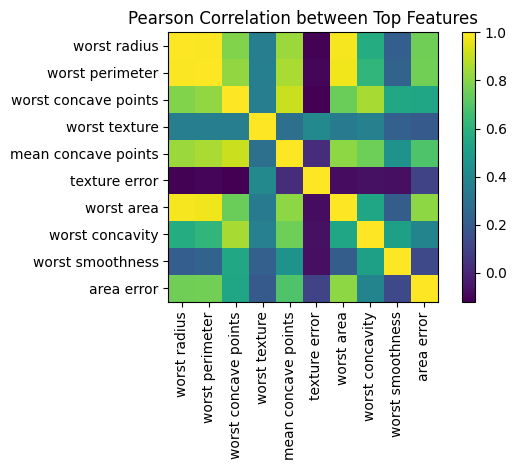

In [9]:
features = pd.Index(top_features + list(rank.head(10).index)).unique()
pearson_corr = X[features].corr()
plt.figure()
plt.imshow(pearson_corr, interpolation='nearest')
plt.xticks(range(pearson_corr.shape[1]), pearson_corr.columns, rotation=90)
plt.yticks(range(pearson_corr.shape[0]), pearson_corr.columns)
plt.colorbar()
plt.title('Pearson Correlation between Top Features')
plt.tight_layout()
plt.show()

- Many radius/perimeter/area shape descriptors are strongly correlated (e.g., mean radius, mean perimeter, mean area), with correlations above 0.9
- This makes sense as larger tumors would imply larger radius, perimeter and area together
- `Worst concave points` also shows high correlation with size features
- `Texture error` and `worst smoothness` have weak or zero correlation with size-related features
- This means that the PDP plots for radius/perimeter/area might distort the PDP interpretations because the model cannot vary one feature independent of the others
- Since features like smoothness and texture error are less correlated, their PDP and ALE interpretations might be more reliable

### PDP and ICE

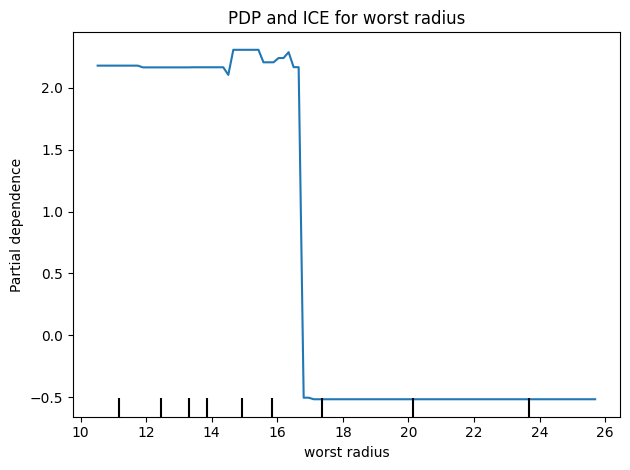

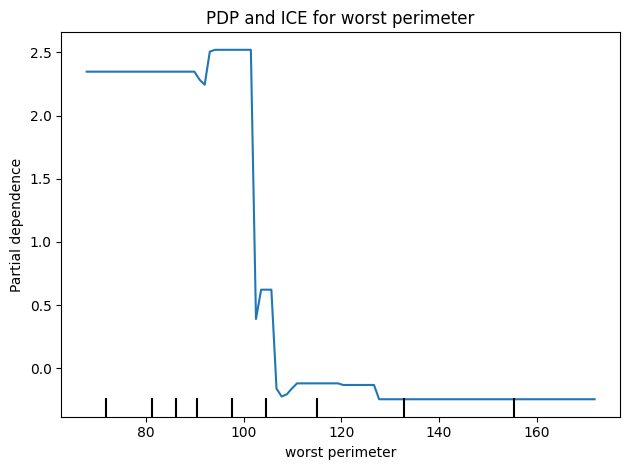

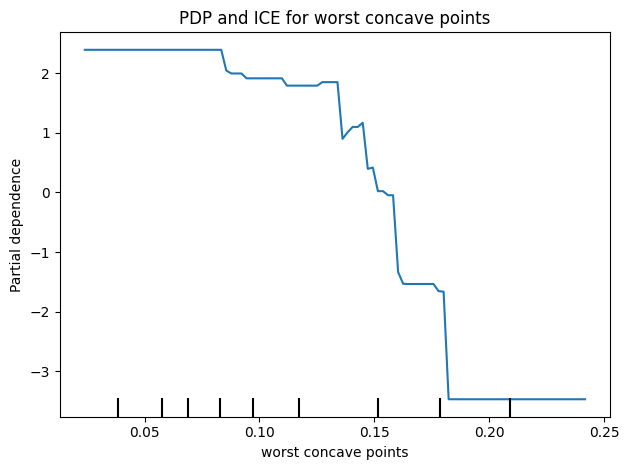

In [10]:
for f in top_features:
    fig, ax = plt.subplots()
    PartialDependenceDisplay.from_estimator(model, X_train, [f], ax=ax, centered=False)
    ax.set_title(f'PDP and ICE for {f}')
    plt.tight_layout()
    plt.show()

*Here are the PDP findings*
1. Worst Radius
 - The partial dependence is showing a steep drop in the predicted probability once the worst radius exceeds around 16
 - Below this threshold, the model outputs higher dependence values (indicating stronger association with malignant cases)
 - After 17, the effect stabilizes at a lower level, suggesting the model considers large radius as decisive evidence for malignancy, and does not increase the risk probability beyond a certain point
 - This shows that at a particular threshold, the probability of malignancy has already been saturated

2. Worst Perimeter
 - The pattern is very similar to worst radius
 - This makes sense as the two are VERY highly correlated
 - PDP is flat at higher values until around 100, and then drops drastically downwards
 - Like radius, this indicates the model sees a perimeter above 100 as a strong signal of malignancy
 - After this point, additional increase in radius provides little predictive power

3. Worst concave points
 - Compared to the other two, there's a more casual decline here
 - The partial dependence steadily decreases as concave points increase from 0.05 to 0.20
 - More concave points = higher risk of malignancy
 - THe PDP curve is less step-like and shows more variability over the range, indicating the model views concave points as progressive risk factor, and not just binary cutoff

Overall Intepretation
 - This PDP indicates that the model has learnt non-linear threshold behaviours for tumor size features like radius and perimeter and gradual risk escalation for shape irregularities like concave points
 - THis step like behaviour reflects the boosting model's tree splits - once a threshold has passed, predictions saturate
 - Because worst radius and worst perimeter are so strongly correlated, their PDPs carry overlapping information
 - ALE plots would reduce the biases that arise due to these correlations

### ALE Plot

In [11]:
def ale_plot(model, X_data, feature, bins=20, pred_fn=None):
    x = X_data[feature].to_numpy()

    #edges of the bins
    quantiles = np.quantile(x, np.linspace(0, 1, bins + 1))
    edges = np.unique(quantiles)
    centers, effects = [], []

    #prediction function
    if pred_fn is None:
        pred_fn = lambda Z: model.predict_proba(Z)[:, 1]

    X_temp = X_data.copy()

    for k in range(len(edges) - 1):
        low, high = edges[k], edges[k + 1]
        mask = (x >= low) & (x < high) if k < len(edges) - 2 else (x >= low) & (x <= high)
        if not np.any(mask):
            continue
        X_low = X_temp.loc[mask].copy()
        X_high = X_temp.loc[mask].copy()

        X_low[feature] = low
        X_high[feature] = high

        pred_diff = pred_fn(X_high) - pred_fn(X_low)

        effects.append(np.mean(pred_diff))
        centers.append((low + high) / 2)

    centers = np.array(centers)
    ale = np.cumsum(effects)
    ale -= np.mean(ale)
    return centers, ale

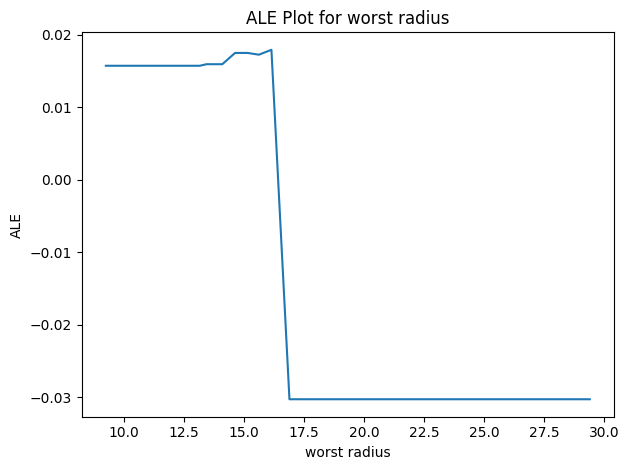

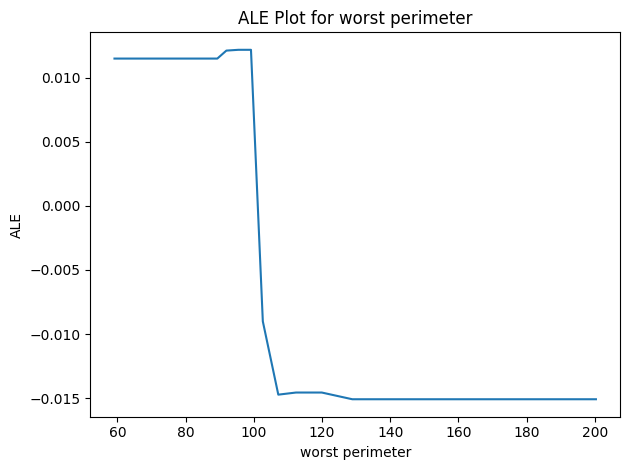

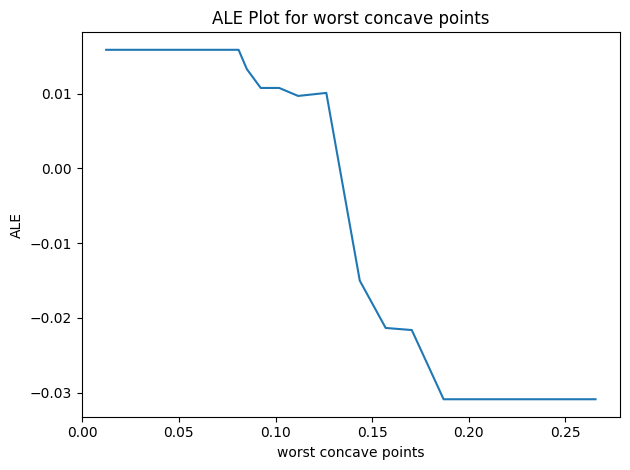

In [12]:
for f in top_features:
    xs, ale = ale_plot(model, X_train, f, bins=20)
    plt.figure()
    plt.plot(xs, ale)
    plt.xlabel(f)
    plt.ylabel('ALE')
    plt.title(f'ALE Plot for {f}')
    plt.tight_layout()
    plt.show()

Here are the ALE findings:

1. Worst Radius
 - The ALE curve is almost flat until 16 and then drops sharply and stabilizes at a negative contribution
 - This means that only when radius exceeds 16 does the feature strongly push the model toward predicting malignancy
 - Unlike PDP, which wsa too steep of a drop, the ALE plot shows a slightly more gradual decrease(not vastly difference though), likely showing the true local contribution without being inflated by correlations


2. Worst Perimeter
 - Shows a very similar threshold - ALE is flat until 100 and then quickly drops
 - The drop is sharp but less exaggerated compared to PDP, again confirming that PDP overstated the strength of the effect because perimeter and radius are highly correlated
 - ALE demonstrates that perimeter’s independent contribution is mostly relevant only around the threshold region

3. Worst Concave Points
 - ALE decreases is gradual across the range, then flattens
 - The negative slope indicates that higher concave points consistently increase malignancy risk, with no sharp threshold like the size-based features
 - This matches the PDP pattern, but the ALE curve is smoother and avoids jumps
 - This shows that the effect is real and robust

PDP vs ALE

- PDP plots exaggerated the strength of `worst radius` and `worst perimeter` becuase they are highly correlatad with the tumour size metrics (area, diameter etc)
- ALE plots are more conservative
- For `worst concave points`, both ALE and PDP show a monotonic risk effect, suggesting this feature is less entangled with the correlated features

In [13]:
print("\nTop 10 features by importance:\n")
print(rank.head(10).round(4))


Top 10 features by importance:

worst radius            0.4355
worst perimeter         0.2715
worst concave points    0.1065
worst texture           0.0526
mean concave points     0.0305
texture error           0.0269
worst area              0.0223
worst concavity         0.0108
worst smoothness        0.0107
area error              0.0053
dtype: float64
